# Expression analyses

This Jupyter notebook reproduces various panels from Figure 2, which characterizes the WapCre;Cdh1F/F;SB tumors in terms of their gene expression profiles. The main analyses focus on identifying the PAM50 subtype of these tumors, and the identification and characterization of tumor subtypes based on gene expression.

In [1]:
%reload_ext autoreload
%reload_ext rpy2.ipython

%autoreload 2
%matplotlib inline

import sys
sys.path.append('../src')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_style('white')

## PAM50 analysis

To establish if the SB-induced mammary tumors model the luminal breast cancer subtype of human ILC, we use the PAM50 gene signature to cluster mouse tumors with human tumors from the TCGA.

First we focus on preparing the different expression datasets.

### Datasets

#### Mouse dataset

For the mouse datasets, we include expression from the SB-tumors and two existing mouse models of luminal breast cancer (WapCre;Cdh1F/F;PtenF/F) and basal-like breast cancer (K14Cre;Brca1F/F;P53F/F). The raw expression counts from these mouse models are combined into a single dataframe and then normalized and log-transformed. We also create a separate design matrix, which contains the corresponding organism of each sample (mouse) and the mouse model from which it was obtained.

In [2]:
import genemap
from nbsupport.expression.util import normalize_counts, plot_count_distribution

samples = pd.read_csv('../data/raw/sb/samples.txt', sep='\t')

# Read counts.
def read_tsv(file_path, *args, index_col=0, **kwargs):
    """Helper function for reading indexed tsv files."""
    return pd.read_csv(file_path, sep='\t', index_col=index_col)

sb_counts = read_tsv('../data/processed/sb/rnaseq/gene_counts.txt')
kb1p_counts = read_tsv('../data/processed/kb1p/gene_counts.txt')
pten_counts = read_tsv('../data/processed/pten/gene_counts.txt')

# Translate SB ids to names.
name_map = dict(zip(samples['rnaseq_id'], samples['sample']))
sb_counts = sb_counts.rename(columns=name_map)

# Merge the datasets.
mouse_counts = pd.concat([sb_counts, kb1p_counts, pten_counts], axis=1)
mouse_counts.dropna(inplace=True)

# Translate to symbols.
mouse_counts = genemap.map_frame(
    mouse_counts, from_type='ensembl', to_type='symbol',
    from_organism='mmusculus', mapper='ensembl')

# Normalize for depth and log transform.
mouse_expr = normalize_counts(mouse_counts)
mouse_expr = np.log2(mouse_expr + 1)

# Define mouse design frame.
def _mouse_model(sample):
    if sample in kb1p_counts.columns:
        return 'Basal-like'
    elif sample in pten_counts.columns:
        return 'Luminal'
    else:
        return 'SB'

mouse_design = pd.DataFrame({
    'sample': mouse_expr.columns,
    'mouse_model': [_mouse_model(s) for s in  mouse_expr.columns],
    'organism': 'mouse',
}).set_index('sample')

#### TCGA dataset

Next, we load the TCGA expression data. The normalized expression counts were downloaded from Firebrowse. The PAM50 subtypes of a subset of these samples were obtained from the supplementary data of the TCGA BRCA publication (2012). To obtain a complete dataset, the expression counts and PAM50 labels are subsetted to the set of shared samples.

Similar to the mouse dataset, the expression counts are log-transformed. We also create a design matrix for the human data, indicating the organism of the samples (human) and the corresponding PAM50 subtype.

In [3]:
# Read and log transform counts.
tcga_expr = pd.read_csv('../data/external/tcga-brca-firebrowse/rnaseqv2.normalized.txt',
                        sep='\t', index_col=0)
tcga_expr = np.log2(tcga_expr + 1)
    
# Build human design matrix.
tcga_design = read_tsv('../data/external/tcga-brca-2012/'
                       'BRCA.547.PAM50.SigClust.Subtypes.txt')[['PAM50']]
tcga_design.rename(columns=dict(PAM50='subtype'), inplace=True)
tcga_design['organism'] = 'human'

# Convert PAM50 to (ordered) categorical.
pam50_order = ['LumA', 'LumB', 'Her2', 'Basal', 'Normal']
tcga_design['subtype'] = pd.Categorical(tcga_design['subtype'], categories=pam50_order)

# Subset to common samples.
common_samples = list(set(tcga_expr.columns) & set(tcga_design.index))

tcga_expr = tcga_expr[common_samples]
tcga_design = tcga_design.ix[common_samples]

tcga_expr.shape

(20502, 539)

#### Combined human/mouse dataset

Finally, we combine the mouse/human datasets by translating the human expression data to mouse gene symbols (via orthogolous genes). The expression and design dataframes are subsequently merged, dropping any genes that are not shared between the mouse/human datasets.

In [4]:
# Map TCGA expression to mouse symbols.
tcga_expr_mm = genemap.map_frame(
    tcga_expr, from_type='symbol', to_type='symbol',
    from_organism='hsapiens', to_organism='mmusculus', mapper='ensembl')

# Combine mouse and human datasets.
combined_expr = pd.concat([mouse_expr, tcga_expr_mm], axis=1).dropna()
combined_design = pd.concat([mouse_design, tcga_design], axis=0)

### Clustering

To perform the actual clustering, we first obtain the list of PAM50 genes and translate these to mouse genes.

In [5]:
# Read list of pam50 genes.
with open('../data/raw/pam50_genes.txt') as file_:
    pam50_human = [line.strip() for line in file_]
    
# Map to mouse symbols.
pam50_mouse = genemap.map_ids(
    pam50_human, from_type='symbol', to_type='symbol',
    from_organism='hsapiens', to_organism='mmusculus', mapper='ensembl')
pam50_mouse = [gene for gene in pam50_mouse if gene is not None]

print('Missing genes: {}'.format(len(pam50_human) - len(pam50_mouse)))

Missing genes: 4


This leaves us with a total of 46 PAM50 genes for which we have mouse orthologues.

Next, we normalize for general differences between the two organisms (mouse and human) using ComBat.

In [6]:
from nbsupport.expression.combat import combat

combat_expr = combat(combined_expr, batch=combined_design['organism'])

Found
 
2
 
batches

Adjusting for
 
0
 
covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data



We then perform hierachical clustering (euclidean distance, average linkage) on the adjusted dataset, using only the mouse PAM50 genes. For clarity, we create two versions of this clustering. The first (used in Figure 2) contains five selected genes, which were chosen to be representative of the general gene expression changes observed across the PAM50 genes. The second (used in the Supplementary Figure) uses the entire (mouse) PAM50 gene set and includes the tumor morphology as additional annotation.

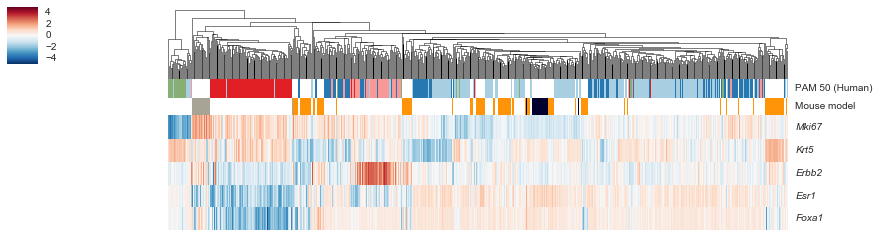

In [7]:
from nbsupport.expression.pam50 import plot_pam50

zoom_genes = ['Mki67', 'Krt5', 'Erbb2', 'Esr1', 'Foxa1']
plot_pam50(combat_expr, combined_design, genes=pam50_mouse, 
           subset=zoom_genes, figsize=(14, 4), row_cluster=False,
           col_ratios={'side_colors': 0.25, 'dendrogram': 0.5}, 
           vmax=5, vmin=-5)

with sns.plotting_context('paper', font_scale=0.7):
    cm = plot_pam50(
        combat_expr, combined_design, genes=pam50_mouse, 
        subset=zoom_genes, figsize=(11, 2), row_cluster=False,
        col_ratios={'side_colors': 0.25, 'dendrogram': 0.5},
        vmax=5, vmin=-5)
    cm.savefig('../reports/figures/fig_2_pam50_zoom.pdf', bbox_inches='tight')
    plt.close(cm.fig)

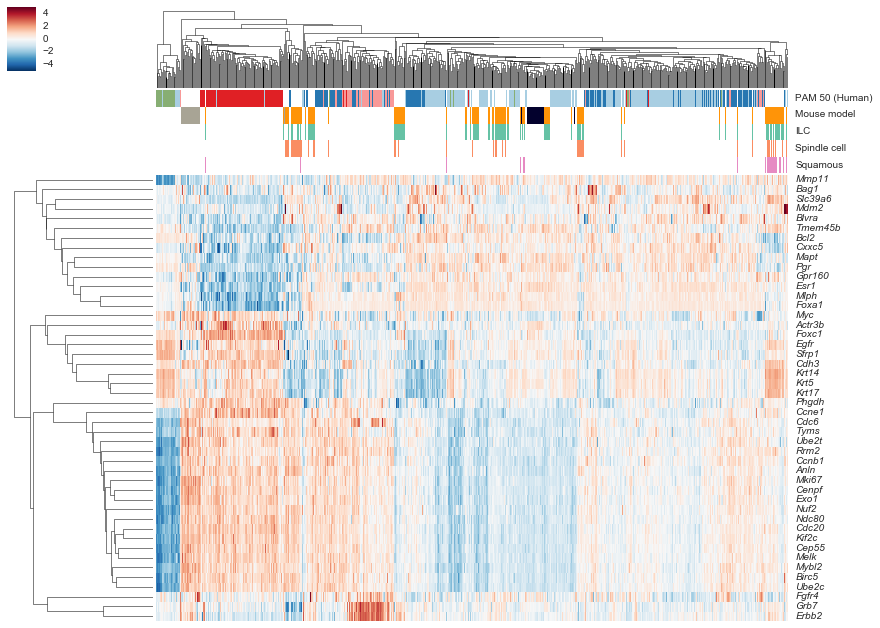

In [8]:
from nbsupport.morphology import parse_morphology, MORPHOLOGY_COLORS
from nbsupport.util.clustermap import color_annotation

morphology = parse_morphology(samples)
morphology_ann = color_annotation(morphology, MORPHOLOGY_COLORS)[0]

plot_pam50(
    combat_expr, combined_design, genes=pam50_mouse, 
    figsize=(14, 11), col_ratios={'side_colors': 0.15},
    extra_annotation=morphology_ann, vmin=-5, vmax=5)

with sns.plotting_context('paper', font_scale=0.7):
    cm = plot_pam50(
        combat_expr, combined_design, genes=pam50_mouse, 
        figsize=(7, 5.2), col_ratios={'side_colors': 0.15},
        extra_annotation=morphology_ann, vmin=-5, vmax=5)
    plt.setp(cm.ax_heatmap.get_yticklabels(), fontsize=5)
    cm.ax_heatmap.set_xlabel('Samples')
    cm.ax_heatmap.set_ylabel('Genes')
    cm.savefig('../reports/supplemental/figures/fig_s2_pam50_tgca.pdf', bbox_inches='tight')
    plt.close(cm.fig)

## Subtype analysis

### NMF factorization

To determine if the SB-induced tumors consist of distinct molecular subtypes, we use non-negative matrix factorization to cluster the tumors by their gene expression profiles.

Due to the computationally intensive nature of this analysis, the analysis is run outside of this notebook. The number of subtypes is determined by performing the NMF analysis for 2-5 clusters (using 30 iterations) and selecting the optimal number of clusters according to the consensus silhouette statistic and the consensus clustering results.

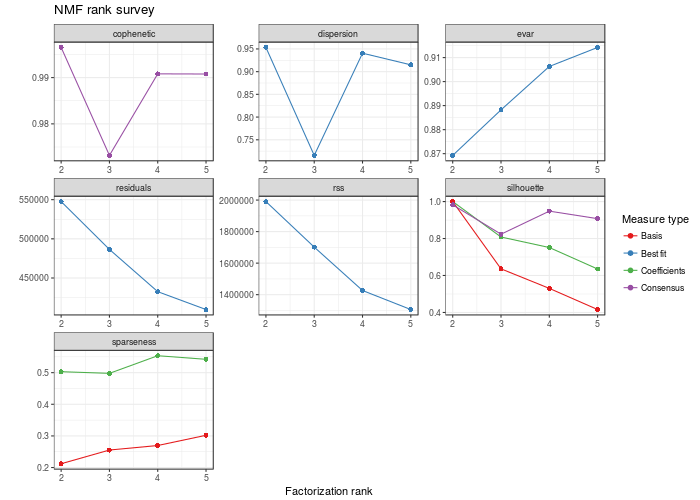

In [9]:
%%R -w 700 -h 500

suppressPackageStartupMessages(library(NMF))

est_rank = readRDS('../data/processed/sb/nmf/rank_estimation.rds')
plot(est_rank)

In [10]:
%%R
pdf('../reports/supplemental/figures/fig_s13_rank_est.pdf', width=10, height=6)
print(plot(est_rank))
dev.off()

pdf('../reports/supplemental/figures/fig_s13_consensus.pdf', width=10, height=10)
print(consensusmap(est_rank))
dev.off()

       [,1]        [,2]        [,3]        [,4]       
Rowv   List,2      List,2      List,2      List,2     
rowInd Integer,123 Integer,123 Integer,123 Integer,123
Colv   List,2      List,2      List,2      List,2     
colInd Integer,123 Integer,123 Integer,123 Integer,123
png 
  2 


These results (the above statistics + consensusmap output) show that four clusters seems to be a good fit for this dataset.

### Naming the subtypes

To actually assign samples to clusters, we run the NMF factorization for again, using four clusters and 200 iterations.

As a sanity check, we plot the subtypes together with the RNA-seq runs to check if the subtypes are the result of batch effects between the sequencing runs.

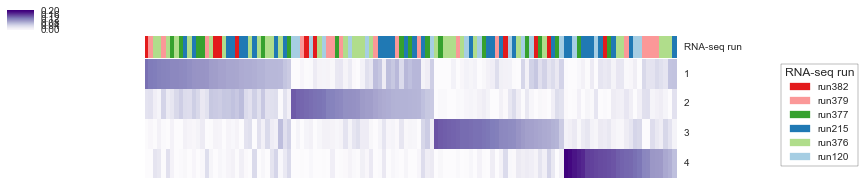

In [19]:
from nbsupport.expression.subtypes import plot_nmf_coefficientmap
from nbsupport.util.clustermap import draw_legend

# Read NMF coefficients and map names.
nmf_coef = pd.read_csv('../data/processed/sb/nmf/coefficients.txt', sep='\t')
nmf_coef.index = [name_map[i] for i in nmf_coef.index]

# Plot with RNA-seq runs.
run_cmap = dict(zip(samples['rnaseq_run'].unique(), sns.color_palette('Paired')))
run_annot = (samples.set_index('sample')['rnaseq_run']
             .map(run_cmap).to_frame(name='RNA-seq run'))

cm = plot_nmf_coefficientmap(nmf_coef, figsize=(12, 3), col_colors=run_annot, 
                             col_ratios=dict(side_colors=0.15))
draw_legend(run_cmap, ax=cm.ax_heatmap, frameon=True, 
            name='RNA-seq run', bbox_to_anchor=(1.35, 1));

This plot shows that none of the subtypes are clearly dominated by a single run. Nor are any of the groups clearly dominated by the newer runs (run376-run382). This indicates that these subtypes are not defined by batch effects between the sequencing runs.

Next, to determine if differences in morphology may play a role in defining these subtypes, we plot the NMF coefficients from the factorization together with the morphology of the tumors. 

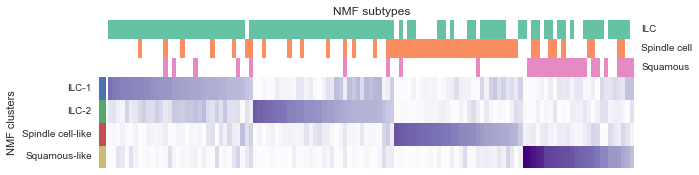

In [20]:
from nbsupport.expression.subtypes import plot_nmf_subtypes

# Plot with putative subtype names.
nmf_coef.columns = ['ILC-1', 'ILC-2', 'Spindle cell-like', 'Squamous-like']
plot_nmf_subtypes(nmf_coef, morphology, figsize=(12, 3))

with sns.plotting_context('paper', font_scale=0.7):
    cm = plot_nmf_subtypes(nmf_coef, morphology, figsize=(9.8, 1.5))
    cm.ax_col_colors.annotate('Morphology', xy=(1.011, 1.06), 
                              xycoords='axes fraction', fontsize=6)
    cm.savefig('../reports/figures/fig_2_nmf_coef.pdf', bbox_inches='tight')
    plt.close(cm.fig)

This shows that clusters 3 and 4 seem to be associated with the Spindle-cell and Squamous morphologies, whilst clusters 1 and 2 are mainly more 'pure' ILC tumors. To confirm this hypothesis, we test for associations between the morphology labels and the subtype assignments using a Fishers Exact test, correcting for multiple testing using Benjamini Hochberg correction.




In [21]:
from IPython.display import display

from nbsupport.expression.subtypes import assign_nmf_subtypes
from nbsupport.enrichment.associations import test_associations

# Assign samples to (putatively named) subtypes.
nmf_subtypes = assign_nmf_subtypes(nmf_coef)

# Test enrichment with morphology.
result = test_associations(
    nmf_subtypes[['subtype']],
    morphology, alternative='greater')

print('Subtypes')
display(result.query('p_value_corr < 0.05'))

# Test enrichment with merged ILC clusters.
merge_map = {'ILC-1': 'ILC', 'ILC-2': 'ILC'}
nmf_subtypes['subtype_merged'] = nmf_subtypes['subtype'].map(
    lambda s: merge_map.get(s, s))

result_merged = test_associations(
    nmf_subtypes[['subtype_merged']],
    morphology, alternative='greater')

print('Merged ILC subtypes')
display(result_merged.query('p_value_corr < 0.05'));

Subtypes


,a,b,p_value,p_value_corr
0,subtype_ILC-1,ILC,2.055167e-03,6.165502e-03
3,subtype_ILC-2,ILC,2.097109e-04,8.388438e-04
7,subtype_Spindle cell-like,Spindle cell,2.969342e-12,1.781605e-11
11,subtype_Squamous-like,Squamous,2.430269e-12,1.781605e-11


Merged ILC subtypes


,a,b,p_value,p_value_corr
0,subtype_merged_ILC,ILC,1.032407e-08,3.097222e-08
4,subtype_merged_Spindle cell-like,Spindle cell,2.969342e-12,1.336204e-11
8,subtype_merged_Squamous-like,Squamous,2.430269e-12,1.336204e-11


These results show that the predicted associations are indeed significant.

To further support these associations, we would like to plot the expression of 'marker' genes for these morphologies across the different subtypes. In this analysis, we would expect expression of these specific marker genes to be higher in the associated subtype than in the other subtypes. 

Based on a literature review, we decided to use a number of EMT genes (*Vim*, *Zeb1* and *Snai1*) as markers for the Spindle cell morphology, whilst using a number of Sqamous markers (*Jag1*, *Trp63* and *Sox2*) for the Squamous morphology.

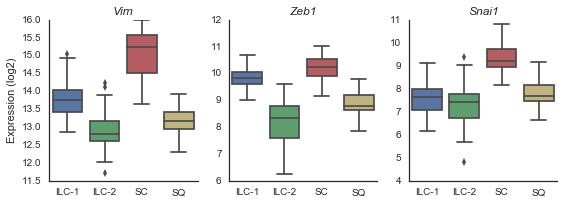

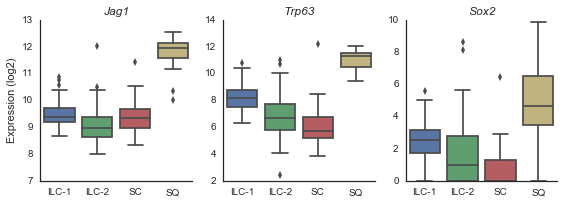

In [22]:
from nbsupport.expression.subtypes import plot_boxplots, SUBTYPE_ORDER, SUBTYPE_COLORS

# Subset expression to SB samples.
sb_expr = mouse_expr[sb_counts.columns]

# Abbreviate subtype names.
abbrv_map = {'Spindle cell-like': 'SC', 'Squamous-like': 'SQ'}
nmf_subtypes_abbrv = nmf_subtypes['subtype'].map(
    lambda x: abbrv_map.get(x, x)).to_frame('subtype')

subtype_order_abbrv = [abbrv_map.get(s, s) for s in SUBTYPE_ORDER]

# Plot EMT gene expression.
emt_genes = ['Vim', 'Zeb1', 'Snai1']

fig, axes = plot_boxplots(
    sb_expr, nmf_subtypes_abbrv,
    genes=emt_genes, figsize=(8, 3),
    order=subtype_order_abbrv, palette=SUBTYPE_COLORS)
axes[0, 0].set_ylabel('Expression (log2)');

# Plot Squamous gene expression.
squamous_genes = ['Jag1', 'Trp63', 'Sox2']

fig, axes = plot_boxplots(
    sb_expr, nmf_subtypes_abbrv,
    genes=squamous_genes, figsize=(8, 3),
    order=subtype_order_abbrv, palette=SUBTYPE_COLORS)
axes[0, 0].set_ylabel('Expression (log2)');


# Plot again for manuscript.
with sns.plotting_context('paper', font_scale=0.7):
    # EMT
    fig, axes = plot_boxplots(
        sb_expr, nmf_subtypes_abbrv,
        genes=emt_genes, figsize=(3.5, 1.4),
        linewidth=0.5, fliersize=2,
        order=subtype_order_abbrv, palette=SUBTYPE_COLORS)
    axes[0, 0].set_ylabel('Expression (log2)')
    
    for ax in fig.axes:
        plt.setp(ax.get_xticklabels(), rotation=25)
    
    fig.suptitle('Spindle cell marker genes', y=1.05, fontsize=7)
    fig.savefig('../reports/supplemental/figures/fig_s2_spindle_cell_genes.pdf',
                bbox_inches='tight')  
    
    plt.close(fig)

    # Squamous
    fig, axes = plot_boxplots(
        sb_expr, nmf_subtypes_abbrv,
        genes=squamous_genes, figsize=(3.5, 1.4),
        linewidth=0.5, fliersize=2,
        order=subtype_order_abbrv, palette=SUBTYPE_COLORS)
    axes[0, 0].set_ylabel('Expression (log2)')
    
    for ax in fig.axes:
        plt.setp(ax.get_xticklabels(), rotation=25)

    fig.suptitle('Squamous marker genes', y=1.05, fontsize=7)
    fig.savefig('../reports/supplemental/figures/fig_s2_squamous_genes.pdf',
                bbox_inches='tight')
    
    plt.close(fig)

These results show higher expression of the selected marker genes in the corresponding subtype. Altogether, this supports the identity of clusters 3 and 4 being related to the Spindle-cell and Squamous morphologies, respectively.

In [23]:
nmf_subtypes.to_csv('../data/processed/sb/nmf/subtypes.txt', sep='\t')

### PAM50 expression across subtypes

To determine if the subytpes also show differences in the expression of the PAM50 genes, we visualize the expression of selected PAM50 genes (*Esr1*, *Foxa1*, *Mki67* and *Krt5*) across the mouse tumor samples. In this case, *Esr1* and *Foxa1* were chosen as luminal markers, whilst *Mki67* represents a marker of proliferation and *Krt5* represents a keratin marker.

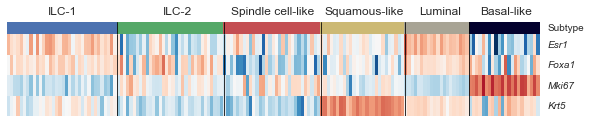

In [24]:
from nbsupport.expression.subtypes import SUBTYPE_ORDER, SUBTYPE_COLORS, plot_heatmap

# Combine expression with subtypes.
mouse_subtypes = pd.concat([mouse_design, nmf_subtypes['subtype']], axis=1)
mouse_subtypes.ix[mouse_subtypes['mouse_model'] == 'Basal-like', 'subtype'] = 'Basal-like'
mouse_subtypes.ix[mouse_subtypes['mouse_model'] == 'Luminal', 'subtype'] = 'Luminal'

# Plot heatmap.
selected_pam50_genes = ['Esr1', 'Foxa1', 'Mki67', 'Krt5']

mouse_order = ['Luminal', 'Basal-like']
mouse_colors = sns.color_palette(sns.xkcd_palette(['greyish', 'midnight']))

combined_order = SUBTYPE_ORDER + mouse_order
combined_colors = SUBTYPE_COLORS + mouse_colors

cm = plot_heatmap(
    mouse_expr, mouse_subtypes, 
    genes=selected_pam50_genes,
    figsize=(12, 2), col_cluster=False,
    order=combined_order, palette=combined_colors,
    col_ratios={'side_colors': 0.12}, colorbar=False)

cm.fig.text(x=0.33, y=0.83, s='ILC-1')
cm.fig.text(x=0.463, y=0.83, s='ILC-2')
cm.fig.text(x=0.542, y=0.83, s='Spindle cell-like')
cm.fig.text(x=0.65, y=0.83, s='Squamous-like')
cm.fig.text(x=0.760, y=0.83, s='Luminal')
cm.fig.text(x=0.830, y=0.83, s='Basal-like')

# Plot again for manuscript.
with sns.plotting_context('paper', font_scale=0.7):
    cm = plot_heatmap(
        mouse_expr, mouse_subtypes,
        genes=selected_pam50_genes,
        figsize=(9.5, 1.3), col_cluster=False,
        order=combined_order, palette=combined_colors,
        col_ratios={'side_colors': 0.12}, colorbar=False,
        vmax=3, vmin=-3)
    
    cm.ax_heatmap.set_xlabel('Samples')

    cm.fig.text(x=0.35, y=0.79, s='ILC-1', ha='center', fontsize=6)
    cm.fig.text(x=0.478, y=0.79, s='ILC-2', ha='center', fontsize=6)
    cm.fig.text(x=0.592, y=0.79, s='Spindle cell-like', ha='center', fontsize=6)
    cm.fig.text(x=0.695, y=0.79, s='Squamous-like', ha='center', fontsize=6)
    cm.fig.text(x=0.78, y=0.79, s='Luminal', ha='center', fontsize=6)
    cm.fig.text(x=0.86, y=0.79, s='Basal-like', ha='center', fontsize=6)
    
    cm.fig.text(x=0.53, y=0.89, s='Subtypes', ha='center', fontsize=6.5)
    cm.fig.text(x=0.82, y=0.89, s='Mouse models', ha='center', fontsize=6.5)
    
    cm.savefig('../reports/figures/fig_2_pam50_heatmap.pdf', bbox_inches='tight')
    plt.close(cm.fig)

We can also summarize the expression of these genes in a boxplot:

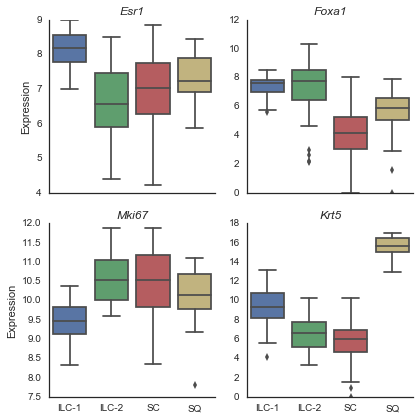

In [25]:
# Draw as boxplot.
selected_pam50_genes = ['Esr1', 'Foxa1', 'Mki67', 'Krt5']

fig, axes = plot_boxplots(
    sb_expr, nmf_subtypes_abbrv,
    genes=selected_pam50_genes, 
    figsize=(6, 6), ncols=2,
    order=subtype_order_abbrv, palette=SUBTYPE_COLORS)

# Draw again for manuscript.
with sns.plotting_context('paper', font_scale=0.7):
    fig, axes = plot_boxplots(
        sb_expr, nmf_subtypes_abbrv,
        genes=selected_pam50_genes, 
        figsize=(3.1, 2.9), ncols=2,
        order=subtype_order_abbrv, palette=SUBTYPE_COLORS,
        linewidth=0.5, fliersize=2)
    axes[0, 0].set_ylabel('')
    axes[1, 0].set_ylabel('')
    axes[0, 0].annotate('Expression (log2)', xy=(0.023, 0.5), 
                        xycoords='figure fraction', va='center', rotation=90)
    fig.savefig('../reports/figures/fig_2_pam50_mouse_boxplot.pdf', bbox_inches='tight')
    plt.close(fig)

Combined, these plots shows that ILC-1 tumors are characterized by high expression of *Esr1*/*Foxa1*, and low expression of *Mki67*. As a result, these tumors most closely reflect the luminal A subtype typical for human ILC. In contrast, ILC-2 and EMT-like tumors generally show lower expression of *Esr1* and higher expression of *Mki67*, indicating that these tumors are more proliferative than ILC-1 tumors. Squamous-like tumors are mainly distinguished by high expression of keratins such as *Krt5*.

Finally, to visualize the expression of the full (mouse) PAM50 gene set and to highlight similarities between the different subtypes, we can also plot the expression of these genes as a clustered heatmap:

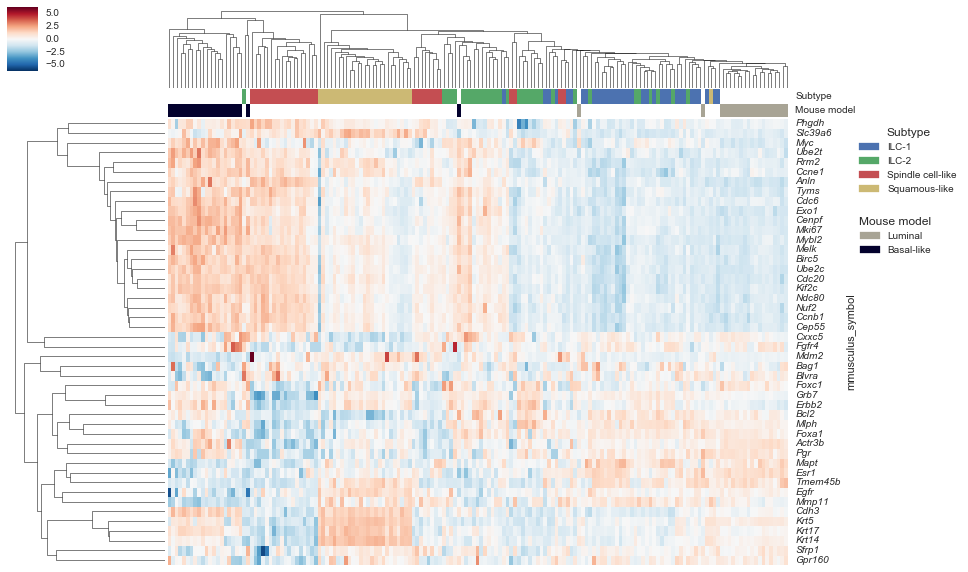

In [26]:
from collections import OrderedDict
from nbsupport.util.clustermap import draw_legend
from nbsupport.util.seaborn import clustermap

mouse_subtypes2 = (
    pd.concat([
        (nmf_subtypes['subtype'].astype('category', categories=SUBTYPE_ORDER)),
        (mouse_design['mouse_model']
             .replace('SB', np.nan)
             .astype('category', categories=mouse_order))
    ], axis=1)
    .rename(columns=lambda c: c.replace('_', ' ').capitalize()))

mouse_annotation, mouse_cmaps = color_annotation(
    mouse_subtypes2, [SUBTYPE_COLORS, mouse_colors])

cm = clustermap(
    mouse_expr.ix[pam50_mouse], z_score=0, 
    method='average', col_colors=mouse_annotation, figsize=(14, 10))
cm.ax_heatmap.set_xticklabels([])
plt.setp(cm.ax_heatmap.get_yticklabels(), rotation=0, fontstyle='italic');

subtype_cmap = OrderedDict(zip(SUBTYPE_ORDER, SUBTYPE_COLORS))
mouse_cmap = OrderedDict(zip(mouse_order, mouse_colors))

legend = draw_legend(mouse_cmap, ax=cm.ax_heatmap, name='Mouse model',
                     bbox_to_anchor=(1.1, 0.8), loc='upper left')
cm.ax_heatmap.add_artist(legend)

draw_legend(subtype_cmap, ax=cm.ax_heatmap, name='Subtype',
            bbox_to_anchor=(1.1, 1.0), loc='upper left')

    
with sns.plotting_context('paper', font_scale=0.7):
    cm = clustermap(
        mouse_expr.ix[pam50_mouse], z_score=0, 
        method='average', col_colors=mouse_annotation, figsize=(7, 5))
    cm.ax_heatmap.set_xticklabels([])
    cm.ax_heatmap.set_ylabel('Genes')
    cm.ax_heatmap.set_xlabel('Samples')
    plt.setp(cm.ax_heatmap.get_yticklabels(), rotation=0, fontstyle='italic', fontsize=5)
    
    legend = draw_legend(
        mouse_cmap, ax=cm.ax_heatmap, name='Mouse model',
        bbox_to_anchor=(1.15, 0.75), loc='upper left')
    cm.ax_heatmap.add_artist(legend)
    
    draw_legend(
        subtype_cmap, ax=cm.ax_heatmap, name='Subtype',
        bbox_to_anchor=(1.15, 1.0), loc='upper left')
    
    cm.savefig('../reports/supplemental/figures/fig_s2_pam50_mouse.pdf', bbox_inches='tight')
    plt.close(cm.fig)

This shows that the ILC-1 subtype is closest to the luminal mouse model, whilst the EMT-like subtype shows expression patterns more similar to the basal mouse tumors.

### Comparison with human ILC subtypes

To explore potential links between our mouse ILC subtypes and the human ILC subtypes (reactive-like, immune-related and proliferative) that were identified in the TCGA ILC study (Ciriello et al., 2015), we compare our mouse ILCs with their human ILCs using the TCGA 60-gene subtype classifier.

To do so, we first load their gene signature and translate the gene symbols to orthologous mouse genes.

In [27]:
import genemap

# Read 60-gene signature and translate to mouse.
signature = (pd.read_excel('../data/external/tcga-ilc-2015/mmc9.xlsx', skiprows=2)
               .get('ILC 60 Gene Classifier').dropna()
               .map(lambda s: s.split('|')[0])
               .pipe(list))

signature_mouse = genemap.map_ids(
    signature, from_type='symbol', to_type='symbol',
    from_organism='hsapiens', to_organism='mmusculus', mapper='ensembl')

signature_mouse = list(filter(bool, signature_mouse))

Next, we read their expression data and subtype labels. In the same fashion as before, we log-transform the expression counts and create a combined dataset containing both the TCGA expression counts and the counts from the SB tumors in the ILC-1 and ILC-2 subtypes. We then normalize the combined counts using ComBat in the same fashion as for the PAM50 analysis.

In [28]:
from nbsupport.expression.combat import combat

# Read tcga expression and subtypes.
tcga_ilc_path = '../data/external/tcga-ilc-2015/ILC_rnaseqv2_RSEM_genes_normalized_data_F2.txt'
subtype_path = '../data/external/tcga-ilc-2015/mmc9.xlsx'

tcga_ilc_expr = (pd.read_csv(tcga_ilc_path, sep='\t', index_col=0)
                   .drop('?').drop('Unnamed: 128', axis=1)
                   .pipe(lambda df: np.log2(df + 1)))

tcga_subtypes = (pd.read_excel(subtype_path, skiprows=3)
                   .get(['Sample ID', 'Dataset', '60 Gene-classifier Class Assignment'])
                   .rename(columns={'Sample ID': 'sample', 'Dataset': 'dataset',
                                    '60 Gene-classifier Class Assignment': 'subtype'})
                   .assign(sample=lambda df: df['sample'].str.replace('.', '-'))
                   .dropna()
                   .query('dataset == "TCGA"')
                   .set_index('sample', drop=False))

# Map to mouse symbols and combine.
tcga_ilc_expr_mm = genemap.map_frame(
    tcga_ilc_expr, from_type='symbol', to_type='symbol',
    from_organism='hsapiens', to_organism='mmusculus', mapper='ensembl')

combined_ilc_expr = pd.concat(
    [sb_expr.ix[signature_mouse], 
     tcga_ilc_expr_mm.ix[signature_mouse]], axis=1)

# Normalize using ComBat.
combat_ilc_design = (
    pd.concat(
        [pd.DataFrame({'sample': tcga_ilc_expr_mm.columns, 'organism': 'human'}),
         pd.DataFrame({'sample': sb_expr.columns, 'organism': 'mouse'})])
    .get(['sample', 'organism']))

combat_ilc_expr = combat(combined_ilc_expr, batch=combat_ilc_design['organism'])

Found
 
2
 
batches

Adjusting for
 
0
 
covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data



Finally, we plot the human and mouse data together using a PCA analysis.

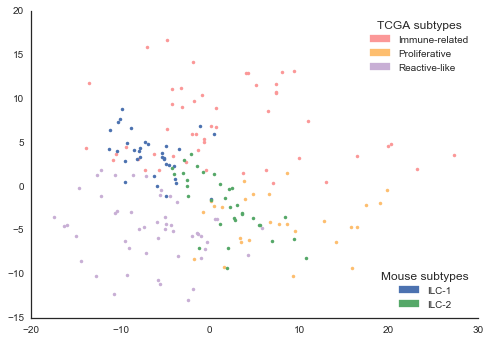

In [35]:
from collections import OrderedDict
from sklearn.decomposition import PCA

from nbsupport.util.clustermap import draw_legend

# Fit PCA.
pca = PCA(n_components=2)
pca.fit(combat_ilc_expr.ix[signature_mouse].T)

# Apply to samples.
x_transform = pd.DataFrame(
    pca.transform(combat_ilc_expr.ix[signature_mouse].T),
    index=combat_ilc_expr.columns)

# Annotate transformation.
merged_subtypes = pd.concat([nmf_subtypes[['subtype']].assign(type='mouse'), 
                             tcga_subtypes[['subtype']].assign(type='human')])
x_transform = pd.concat([x_transform, merged_subtypes], axis=1)


def _plot_pca(ax=None):
    # Setup figure.
    if ax is None:
        _, ax = plt.subplots()

    # Plot tcga samples.
    paired_colors = sns.color_palette('Paired', 12)
    
    tcga_cmap = OrderedDict(
        zip(['Immune-related', 'Proliferative', 'Reactive-like'],
            [paired_colors[i] for i in [4, 6, 8]]))

    for subtype, color in tcga_cmap.items():
        grp = x_transform.ix[x_transform['subtype'] == subtype]
        ax.plot(grp[0], grp[1], '.', color=color, label=subtype)

    legend = draw_legend(tcga_cmap, ax=ax, name='TCGA subtypes', loc='upper right')
    ax.add_artist(legend)

    # Plot mouse samples.
    mouse_cmap = OrderedDict(zip(SUBTYPE_ORDER[:2], SUBTYPE_COLORS))
    
    for subtype, color in mouse_cmap.items():
        grp = x_transform.ix[x_transform['subtype'] == subtype]
        ax.plot(grp[0], grp[1], '.', color=color, label=subtype)

    draw_legend(mouse_cmap, ax=ax, name='Mouse subtypes', loc='lower right')
        
    sns.despine()
    
    return ax
    
_plot_pca()

with sns.plotting_context('paper', font_scale=0.7):
    fig, ax = plt.subplots(figsize=(4.8, 3))
    _plot_pca(ax=ax)
    ax.set_title('PCA of human (TCGA) and mouse ILC subtypes')
    fig.savefig('../reports/figures/fig_2_human_subtypes.pdf', bbox_inches='tight')
    plt.close(fig)

This shows that ILC-2 tumors are more similar to the proliferative human subtype, which is also supported by the relatively higher expression of Mki67 in ILC-2, whilst ILC-1 tumors reflect the immune-related human subtype.